# 流程

整体包括数据预处理、特征提取、单模型、多模型融合、trick部分。

In [19]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn
import jieba
import pandas as pd 
from wordcloud import WordCloud, STOPWORDS
# 这里是基于mac平台的，如果移植到了其他平台，请修改family字体
plt.rc('font', family='Arial Unicode MS', size=13)

# 1. 查看数据

先查看训练数据、测试数据的分布

In [20]:
pwd = %pwd
pwd

'/Users/xuming06/Codes/fake-news-detector'

In [33]:
df = pd.read_csv(pwd + '/data/train_sample.csv')
df.head()

,id,text,label
0,09766d6ec92a9eff7f8763f9f9fee14f,＂李的76人律师团领队、法律大学副校长张爱国教授对媒体表示，李天一因第一个与被害女子发生性关...,1
1,1cdf439752d339b45fc848984c609899,【男子捏造“周浦滴滴司机砍死乘客”谣言被刑拘称只是觉得好玩】,0
2,d3aa07cc41ab42fa5c8718bd655abb1c,【善良的大桥】金沙江大桥在没车行走的时候自我坍塌，这桥通人性，未伤一车一人，太善良了。应该当...,1
3,e940e98292b76024dfbcbcff378c9d2f,幼儿园都发通知了，家长们注意啦：现在得白血病的小孩越来越多，妇幼保健院提示您，请不要给宝宝喝...,1
4,21b667ed6784407bf5562a400c72bb3f,上海4000吨垃圾偷倒苏州太湖西山岛(图)（分享自@新浪新闻）,0


# 2. 特征提取

先对训练数据做特征提取

In [64]:
origin_train_file = pwd + '/data/train_sample.csv'
origin_test_file = pwd + '/data/test_sample.csv'

train_file = pwd + '/data/train_sample_segment.csv'
test_file = pwd + '/data/test_sample_segment.csv'

In [65]:
# 文本切词
ID_TEXT = {}
ID_LABEL = {}
LABEL_ID = {}

def segment_file(in_file_path, out_file_path, file_type='train'):
    result = []
    with open(in_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            parts = line.split(",")
            if file_type == 'train':
                if len(parts) < 3:
                    print('error\t', line)
                    continue

                id = parts[0]
                text = parts[1]
                text_segment = " ".join(jieba.lcut(text))
                label = parts[2]
                ID_TEXT[id] = text_segment
                ID_LABEL[id] = label
                if label not in LABEL_ID:
                    LABEL_ID[label] = [id]
                else:
                    t = LABEL_ID[label]
                    t.append(id)
                    LABEL_ID[label] = t
                result.append(",".join([id, text, text_segment, label]))
            else:
                if len(parts) < 2:
                    print('error\t', line)
                    continue

                id = parts[0]
                text = parts[1]
                text_segment = " ".join(jieba.lcut(text))
                ID_TEXT[id] = text_segment
                result.append(",".join([id, text, text_segment]))

    with open(out_file_path, 'w', encoding='utf-8') as f:
        for line in result:
            f.write(line + '\n')
    print(in_file_path, ' to: ', out_file_path)

segment_file(origin_train_file, train_file, file_type='train')
segment_file(origin_test_file, test_file, file_type='test')

/Users/xuming06/Codes/fake-news-detector/data/train_sample.csv  to:  /Users/xuming06/Codes/fake-news-detector/data/train_sample_segment.csv
/Users/xuming06/Codes/fake-news-detector/data/test_sample.csv  to:  /Users/xuming06/Codes/fake-news-detector/data/test_sample_segment.csv


In [66]:
df_train = pd.read_csv(train_file)
df_train.head()

,id,text,text.1,label
0,09766d6ec92a9eff7f8763f9f9fee14f,＂李的76人律师团领队、法律大学副校长张爱国教授对媒体表示，李天一因第一个与被害女子发生性关...,＂ 李 的 76 人 律师团 领队 、 法律 大学 副校长 张 爱国 教授 对 媒体 表示 ...,1.0
1,1cdf439752d339b45fc848984c609899,【男子捏造“周浦滴滴司机砍死乘客”谣言被刑拘称只是觉得好玩】,【 男子 捏造 “ 周浦 滴滴 司机 砍死 乘客 ” 谣言 被 刑拘 称 只是 觉得 好玩 】,0.0
2,d3aa07cc41ab42fa5c8718bd655abb1c,【善良的大桥】金沙江大桥在没车行走的时候自我坍塌，这桥通人性，未伤一车一人，太善良了。应该当...,【 善良 的 大桥 】 金沙江 大桥 在 没车 行走 的 时候 自我 坍塌 ， 这桥通 人性...,1.0
3,e940e98292b76024dfbcbcff378c9d2f,幼儿园都发通知了，家长们注意啦：现在得白血病的小孩越来越多，妇幼保健院提示您，请不要给宝宝喝...,幼儿园 都 发 通知 了 ， 家长 们 注意 啦 ： 现在 得 白血病 的 小孩 越来越 多...,1.0
4,21b667ed6784407bf5562a400c72bb3f,上海4000吨垃圾偷倒苏州太湖西山岛(图)（分享自@新浪新闻）,上海 4000 吨 垃圾 偷倒 苏州 太湖 西山 岛 ( 图 ) （ 分享 自 @ 新浪 新闻 ）,0.0


In [67]:
df_test = pd.read_csv(test_file)
df_test.head()

,id,text,text.1
0,4eb870bf91f8f06d4b8394a5016fc1c2,中国缺医院吗？不缺！中国缺医生吗？不缺！中国缺药物吗？不缺！那为什么医院还那么拥挤？...,中国 缺 医院 吗 ？ 不缺 ！ 中国 缺 医生 吗 ？ 不缺 ！ 中国 缺 药物 吗 ？ ...
1,7b67f10cb7bd3b6df8e5a224df28d2dd,又要降温了，街坊们注意及时添加衣物🙈http://t.cn/RfiEgRu|南安市,又 要 降温 了 ， 街坊 们 注意 及时 添加 衣物 🙈 http : / / t . c...
2,0f47c61b8d7e637d73ad05f93d047de8,昨晚东航飞上海，又是流量控制，不出所料地晚点近两小时。翻看《人物》，封面是郭敬明。他提到给韩...,昨晚 东航 飞 上海 ， 又 是 流量 控制 ， 不出所料 地 晚点 近 两 小时 。 翻看...
3,7b52177f60c35d75c050a2e6d4bcd2e7,【再次呼吁建栏杆国家标准。将栏杆连接片抬高即可避免悲剧！】陕西一孕妇脖子卡入公路栏杆身亡。北...,【 再次 呼吁 建 栏杆 国家标准 。 将 栏杆 连接 片 抬高 即可 避免 悲剧 ！ 】 ...
4,ea3009bb7beceacbc539f527c2beecb9,图：杨振宁82岁娶了28岁的翁帆如今翁忛68-我爱八娱业主论坛-广州搜狐焦点杨振宁82岁时娶...,图 ： 杨振宁 82 岁 娶 了 28 岁 的 翁帆 如今 翁 忛 68 - 我 爱八娱 业...


In [68]:
print('标记为0类(真实)的新闻个数有:', len(LABEL_ID['0']), '个')
print('标记为1类(虚假)的新闻个数有:', len(LABEL_ID['1']), '个')

标记为0类(真实)的新闻个数有: 44 个
标记为1类(虚假)的新闻个数有: 46 个


# 3. 关键词提取
查看各个类别的词频，经常出现的词是哪些

fake text size: 46 ['＂ 李 的 76 人 律师团 领队 、 法律 大学 副校长 张 爱国 教授 对 媒体 表示 ， 李 天一 因 第一个 与 被害 女子 发生 性关系 ， 不 构成 轮奸 罪 ， 只是 以 判罚 较轻 的 强奸罪 批捕 ， 这是 律师团 所有 成员 共同努力 的 结果 。 ＂ 果断 记下 律师 大名 ， 犯了罪 找 爱国 ， 没错 ！ 尤其 轮奸 后 。', '【 善良 的 大桥 】 金沙江 大桥 在 没车 行走 的 时候 自我 坍塌 ， 这桥通 人性 ， 未伤 一车 一人 ， 太 善良 了 。 应该 当选 2013 年度 《 感动 中国 》 特别 致敬 者 。 （ by 夏骏 ）', '幼儿园 都 发 通知 了 ， 家长 们 注意 啦 ： 现在 得 白血病 的 小孩 越来越 多 ， 妇幼保健 院 提示 您 ， 请 不要 给 宝宝 喝 爽歪歪 和 有 添加剂 的 牛奶 饮料 ， 告诉 家里 有 小孩 的 朋友 ， 旺仔 牛奶 、 可口可乐 、 爽歪歪 、 娃哈哈 AD 钙奶 、 未来 星 、 QQ 星 、 美汁 源果 粒奶 优 菠萝 味 的 。 都 含有 肉毒 杆菌 。 现在 紧急 召回 。 请 转发 扩散 ！ ！ ！', '也 是 会 很 辛苦 。 然后 … … 面对 着 汹涌 而来 的 现实 觉得 自己 渺小 无力 ： 不要 害怕 。 这个 过程 是 会 很 痛 的 … … 一 男子 闯入 午托 居民 屋刀 砍 16 名 儿童 致 3 死 13 伤 、 广西 平南 、 做好 现在 你 能 做 的 2 苏州 · 左邻右里 （ 黑椒 厨房 ）', '[ 抱拳 ] 急 找 孩子 ， 求 帮忙 实验 小学 寻人启事 13759695559 帮忙 扩散 ， 今天上午 一个三岁 多 小女孩 在 锦绣 花园 小区 附近 被 人 拐走 了 ， 小女孩 能 说出 她 爸爸 的 手机号码 从 监控 上 看 是 被 一个四十多岁 男人 抱 走 了 现 大人 都 急 疯 了 有 知情者 请告 之 万分 感谢 看到 信息 的 兄弟姐妹 留意 一下 联系人 张静杰 13759695559']


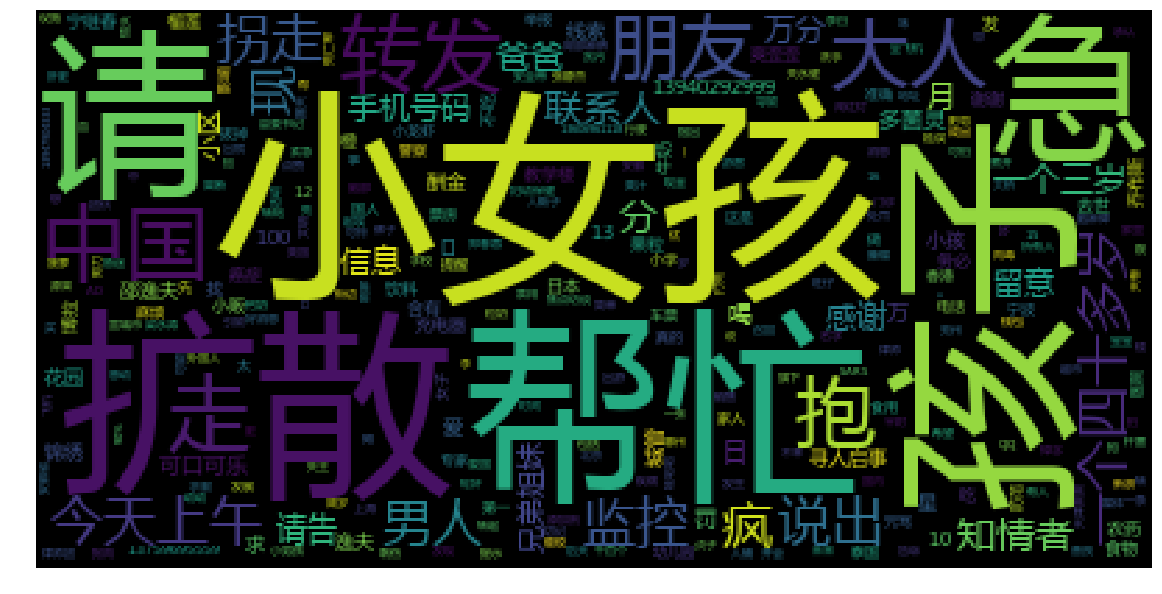

In [71]:
fake_text = []
for ids in LABEL_ID["1"]:
    fake_text.append(ID_TEXT[ids])

print("fake text size:", len(fake_text), fake_text[:5])
# 加载停用词
stopwords = []
with open(pwd + '/data/stopwords.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        stopwords.append(line)

word_seg = {}
for text in fake_text:
    text = text.split(" ")
    for word in text:
        frequent = word_seg.get(word, 0)
        if word not in stopwords:
            word_seg[word] = frequent + 1
wc = WordCloud(font_path=pwd + "/src/preprocess/msyh.ttf", background_color="black", max_words=2000)
wc.generate_from_frequencies(word_seg)
plt.figure(figsize=(20, 20))

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False
plt.imshow(wc)
# 是否显示x轴、y轴下标
plt.axis('off')
plt.show()